In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot
import gc

In [2]:
# Load data
browsing_path = r"D:\Data\Documents\recsys\SIGIR-ecom-data-challenge\train\browsing_train.csv"
data = pd.read_csv(browsing_path)

# Add event_product column (type of event + type of product)
data[['event_type', 'product_action']] = data[['event_type', 'product_action']].fillna("NaN")
data['event_product'] = data['event_type'] + '/' + data['product_action']

# Compute what are the combinations of events and products
event_action = data['event_product'].value_counts(dropna=False)
uniques = data.nunique()

In [3]:
# Display some info about the dataset
print("Data shape: ", data.shape)
print("\nData columns:\n", data.columns.to_list())
print("\nUniques:\n", uniques)
print("\nEvent_product:\n", event_action)

Data shape:  (36079307, 7)

Data columns:
 ['session_id_hash', 'event_type', 'product_action', 'product_sku_hash', 'server_timestamp_epoch_ms', 'hashed_url', 'event_product']

Uniques:
 session_id_hash               4934699
event_type                          2
product_action                      5
product_sku_hash                57483
server_timestamp_epoch_ms    26219566
hashed_url                     489300
event_product                       5
dtype: int64

Event_product:
 pageview/NaN              25647696
event_product/detail       9707890
event_product/add           329557
event_product/remove        316316
event_product/purchase       77848
Name: event_product, dtype: int64


# sessions  = 0 product:  1958881.0
# sessions  = 1 product:  553270.0
# sessions >= 2 products:  768433.0


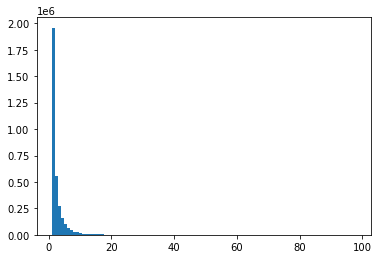

In [4]:
# Keep only session and product ids columns
# Drop lines that dont concern products 
data_ = data[['session_id_hash', 'product_sku_hash']].dropna(subset='product_sku_hash')
products_in_session = data_.groupby(by='session_id_hash')
hist = pyplot.hist(products_in_session.nunique().to_numpy(), bins=100)
print("# sessions  = 1 product: ", hist[0][0])
print("# sessions  = 2 product: ", hist[0][1])
print("# sessions >= 3 products: ", hist[0][2:].sum())

In [5]:
del(data)
print("1:", len(data_))

# Compute the the pairs of 'products' in a same 'session'
data_ = pd.merge(data_, data_, on='session_id_hash', suffixes=("_1", "_2"))
print("2:", len(data_))

# Drop duplicates of the same pair of products (A B on several rows)
data_ = data_.drop_duplicates()
print("3:", len(data_))

# Drop pairs of the same product (A A on a row)
data_ = data_[data_['product_sku_hash_1']!=data_['product_sku_hash_2']]
print("4:", len(data_))

# Transform the DataFrame into a list
data_ = data_[['session_id_hash', 'product_sku_hash_1', 'product_sku_hash_2']].values.tolist()
print("5:", len(data_))

# Transform the list into a set to discard pairs of same products (A B and B A)
data_ = {frozenset(l) for l in data_}
print("6:", len(data_))

# Transform into a DataFrame and save to a csv
data_=pd.DataFrame(data_)
data_.columns = [['session_id_hash', 'product_sku_hash_1', 'product_sku_hash_2']]
print("7:", len(data_))
data_.to_csv("pairs.csv")

1: 10431611
2: 109923643
3: 38963186
4: 31706918
5: 31706918
6: 15853459
7: 15853459


In [ ]:
hist = pyplot.hist(products_in_session.nunique().to_numpy(), bins=100)
print("# sessions  = 0 product: ", hist[0][0])
print("# sessions  = 1 product: ", hist[0][1])
print("# sessions >= 2 products: ", hist[0][2:].sum())

In [ ]:
products_in_session = products_in_session.dropna

In [ ]:
from itertools import combinations

for name, group in products_in_session:
    print("Name: ", name)
    print("Group:\n", combinations(group.unique(),2))
    break

In [ ]:
list(combinations(group.unique(),2))

In [ ]:
data[data["session_id_hash"]=='00000114e1075962f022114fcfc17f2d874e694ac5d2010985bbba0a595340db']

In [ ]:
input_embeddings = [[
    "Salut", "comment", "ca", "va", "?",
]]

output_embeddings = [[
    "<START>", "Hi", "how", "are", "you", "?",
]]
print(input_embeddings)
print(output_embeddings)

In [ ]:
def get_vocabulary(sequences):

    token_to_info = {}

    for sequence in sequences:
        for word in sequence:
            if word not in token_to_info:
                token_to_info[word] = len(token_to_info)
    return token_to_info

input_voc = get_vocabulary(input_embeddings)
output_voc = get_vocabulary(output_embeddings)

input_voc["<START>"] = len(input_voc)
input_voc["<END>"] = len(input_voc)
input_voc["<PAD>"] = len(input_voc)

output_voc["<END>"] = len(output_voc)
output_voc["<PAD>"] = len(output_voc)

print(input_voc)
print(output_voc)

In [ ]:
def sequences_to_int(sequences, voc):
    for sequence in sequences:
        for s, word in enumerate(sequence):
            sequence[s] = voc[word]
    return(np.array(sequences))

input_seq = sequences_to_int(input_embeddings, input_voc)
output_seq = sequences_to_int(output_embeddings, output_voc)

print(input_seq)
print(output_seq)

In [ ]:
class EmbeddingLayer(tf.keras.layers.Layer):

    def __init__(self, nb_token, **kwargs):
        self.nb_token = nb_token
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.word_embedding = tf.keras.layers.Embedding(
            self.nb_token, 256,
        )
        super().build(input_shape)

    def call(self, x):
        embed = self.word_embedding(x)
        return embed


class ScaledDotProductAttention(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.query_layer = tf.keras.layers.Dense(256)
        self.value_layer = tf.keras.layers.Dense(256)
        self.key_layer = tf.keras.layers.Dense(256)
        super().build(input_shape)

    def call(self, x):
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)
        QK = tf.matmul(Q, K, transpose_b=True)
        QK = QK / tf.math.sqrt(256.)
        softmax_QK = tf.nn.softmax(QK, axis=-1)
        attention = tf.matmul(softmax_QK, V)
        # print("Shape Q", Q.shape)
        # print("Shape K", K.shape)
        # print("Shape V", V.shape)
        # print("Shape QK", QK.shape)
        # print("Shape softmax", softmax_QK.shape)
        # print("Shape attention", attention.shape)
        return attention

def test():
    layer_input = tf.keras.Input(shape=(5))
    embedding = EmbeddingLayer(nb_token=5)(layer_input)
    attention = ScaledDotProductAttention()(embedding)
    model = tf.keras.Model(layer_input, attention)
    #model.summary()
    return model

m_test = test()
out = m_test(input_seq)
print(out.shape)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, dim=256, nb_head=8, **kwargs):
        self.dim = 256
        self.head_dim = 256 // 8
        self.nb_head = nb_head
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.query_layer = tf.keras.layers.Dense(256)
        self.value_layer = tf.keras.layers.Dense(256)
        self.key_layer = tf.keras.layers.Dense(256)
        self.out_proj = tf.keras.layers.Dense(256)
        super().build(input_shape)

    def mask_softmax(self, x, mask):
        x_expe = tf.math.exp(x)
        x_expe_masked = x_expe * mask
        x_expe_sum = tf.reduce_sum(x_expe_masked, axis = -1)
        x_expe_sum = tf.expand_dims(x_expe_sum, axis=-1)
        softmax = x_expe_masked / x_expe_sum
        return softmax

    def call(self, x, mask = None):

        in_query, in_key, in_value = x

        Q = self.query_layer(in_query)
        K = self.key_layer(in_key)
        V = self.value_layer(in_value)

        batch_size = tf.shape(Q)[0]
        Q_seq_len = tf.shape(Q)[1]
        K_seq_len = tf.shape(K)[1]
        V_seq_len = tf.shape(V)[1]

        Q = tf.reshape(Q, [batch_size, Q_seq_len, self.nb_head, self.head_dim])
        K = tf.reshape(K, [batch_size, K_seq_len, self.nb_head, self.head_dim])
        V = tf.reshape(V, [batch_size, V_seq_len, self.nb_head, self.head_dim])

        Q = tf.transpose(Q, [0, 2, 1, 3])
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])

        Q = tf.reshape(Q, [batch_size * self.nb_head, Q_seq_len, self.head_dim])
        K = tf.reshape(K, [batch_size * self.nb_head, K_seq_len, self.head_dim])
        V = tf.reshape(V, [batch_size * self.nb_head, V_seq_len, self.head_dim])

        # Scaled dot product attention
        QK = tf.matmul(Q, K, transpose_b=True)
        QK = QK / tf.math.sqrt(256.)

        if mask is not None:
            QK = QK * mask
            softmax_QK = self.mask_softmax(QK, mask)
        else:
            softmax_QK = tf.nn.softmax(QK, axis=-1)

        attention = tf.matmul(softmax_QK, V)
        attention = tf.reshape(attention, [batch_size, self.nb_head, Q_seq_len, self.head_dim])
        attention = tf.transpose(attention, [0, 2, 1, 3])

        # Concat
        attention = tf.reshape(attention, [batch_size, Q_seq_len, self.nb_head * self.head_dim])

        out_attention = self.out_proj(attention)

        return out_attention

def test():
    layer_input = tf.keras.Input(shape=(6))
    embedding = EmbeddingLayer(nb_token=6)(layer_input)

    mask = tf.sequence_mask(tf.range(6) + 1, 6)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=0)
    multi_attention = MultiHeadAttention()((embedding,embedding, embedding), mask =mask)

    model = tf.keras.Model(layer_input, multi_attention)
    model.summary()
    return model

m_test = test()
out = m_test(output_seq)
print(out.shape)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.multi_head_attention = MultiHeadAttention()
        self.norm = tf.keras.layers.LayerNormalization()
        self.dense_out = tf.keras.layers.Dense(256)
        super().build(input_shape)

    def call(self, x):
        attention = self.multi_head_attention((x, x, x))
        post_attention = self.norm(x + attention)
        x = self.dense_out(post_attention)
        enc_output = self.norm(x + post_attention)
        return enc_output

class Encoder(tf.keras.layers.Layer):

    def __init__(self, nb_encoder, **kwargs):
        self.nb_encoder = nb_encoder
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.encoder_layers = []
        for nb in range(self.nb_encoder):
            self.encoder_layers.append(
                EncoderLayer()
            )
        super().build(input_shape)

    def call(self, x):

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

def test():
    layer_input = tf.keras.Input(shape=(5))
    embedding = EmbeddingLayer(nb_token=5)(layer_input)
    enc_output = Encoder(nb_encoder=6)(embedding)
    model = tf.keras.Model(layer_input, enc_output)
    model.summary()
    return model

m_test = test()
out = m_test(input_seq)
print(out.shape)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.multi_head_self_attention = MultiHeadAttention()
        self.multi_head_enc_attention = MultiHeadAttention()
        self.norm = tf.keras.layers.LayerNormalization()
        self.proj_output = tf.keras.layers.Dense(256)
        super().build(input_shape)

    def call(self, x):
        enc_output, output_embedding, mask = x
        self_attention = self.multi_head_self_attention((output_embedding, output_embedding, output_embedding), mask)
        post_self_att = self.norm(output_embedding + self_attention)
        enc_attention = self.multi_head_enc_attention((post_self_att, enc_output, enc_output)) # Pas sur de l'ordre
        post_enc_attention = self.norm(enc_attention + post_self_att)
        proj_out = self.proj_output(post_enc_attention)
        dec_output = self.norm(proj_out + post_enc_attention)
        return dec_output

class Decoder(tf.keras.layers.Layer):

    def __init__(self, nb_decoder, **kwargs):
        self.nb_decoder = nb_decoder
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.decoder_layers = []
        for nb in range(self.nb_decoder):
            self.decoder_layers.append(
                DecoderLayer()
            )
        super().build(input_shape)

    def call(self, x):

        enc_out, output_embedding, mask = x
        dec_output = output_embedding
        for decoder_layer in self.decoder_layers:
            dec_output = decoder_layer((enc_out, dec_output, mask))
        return dec_output

def test():
    input_token = tf.keras.Input(shape=(5))
    output_token = tf.keras.Input(shape=(6))

    # Retrieve embedding
    input_embedding = EmbeddingLayer(nb_token=5)(input_token)
    output_embedding = EmbeddingLayer(nb_token=6)(output_token)

    # Encoder
    enc_output = Encoder(nb_encoder=6)(input_embedding)

    # mask
    mask = tf.sequence_mask(tf.range(6) + 1, 6)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=0)

    # Decoder
    dec_output = Decoder(nb_decoder=6)((enc_output, output_embedding, mask))

    model = tf.keras.Model([input_token, output_token], dec_output)
    model.summary()
    return model

m_test = test()
out = m_test((input_seq, output_seq))
print(out.shape)